# 小批量随机梯度下降
## 向量化和缓存

In [1]:
%matplotlib inline
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

timer = d2l.Timer()
A = torch.zeros(256, 256)
B = torch.randn(256, 256) # 元素服从标准正态分布（均值为0，标准差为1）
C = torch.randn(256, 256)

按元素分配只需遍历分别为$\mathbf{B}$和$\mathbf{C}$的所有行和列，即可将该值分配给$\mathbf{A}$。


In [2]:
# 逐元素计算A=B×C
'''
B[i,:]：B的第i行（形状[256]）
C[:,j]：C的第j列（形状[256]）
torch.dot()：计算两个向量的点积（元素相乘后求和）
赋值：将点积结果存入 A[i,j]
'''
timer.start()
for i in range(256):
    for j in range(256):
        A[i, j] = torch.dot(B[i, :], C[:, j])
timer.stop()

3.774756669998169

更快的策略是执行按列分配。


In [3]:
# 逐列计算A=BC
timer.start()
for j in range(256):
    '''
    C[:,j]：提取C的第j列→形状[256]（列向量）
    torch.mv(B,C[:,j])：mv=matrix-vector multiplication（矩阵-向量乘法）
    B：256×256矩阵
    C[:,j]：256维向量
    结果：256维向量（B与C的第j列相乘）
    A[:,j]=...：将结果向量赋值给A的第j列
    '''
    A[:, j] = torch.mv(B, C[:, j])
timer.stop()

0.0697336196899414

最有效的方法是在一个区块中执行整个操作。让我们看看它们各自的操作速度是多少。


实际Gigaflops公式应为:$Gflops=\frac{总FLOPs}{10^{9}\times 时间（秒）}$<br>

$Gflops=\frac{2}{时间}$

| 索引                 | 实现方式          | 典型耗时 (256×256) | `gigaflops[1]` 的值 |
| ------------------ | ------------- | -------------- | ----------------- |
| `gigaflops[0]`     |  嵌套循环 | ~0.5秒          | ~0.004            |
| **`gigaflops[1]`** | **列向量化**      | **~0.001秒**    | **~2000**         |
| `gigaflops[2]`     | `torch.mm`    | ~0.0002秒       | ~10000            |


In [4]:
# 一次性计算A=BC
timer.start()
A = torch.mm(B, C)
timer.stop()

# 乘法和加法作为单独的操作（在实践中融合）
'''
Gigaflops=十亿次浮点运算/秒
对于256×256矩阵乘法：
运算量：每个元素需要256次乘法和256次加法=512 FLOPs;总元素：256×256=65536个元素
总FLOPs：65536×256≈16777216=16.78 MFLOPs
简化计算：
实际中常用近似：每个元素≈2×维度FLOPs（乘法和加法各一次）
总FLOPs≈2×256³=33554432=33.55 MFLOPs
归一化：代码中2/i的"2"是归一化系数，表示单位计算量
i是秒为单位的耗时;2/i得到相对性能指标（越高越好）
'''
gigaflops = [2/i for i in timer.times]
print(f'performance in Gigaflops: element {gigaflops[0]:.3f}, '
      f'column {gigaflops[1]:.3f}, full {gigaflops[2]:.3f}')

performance in Gigaflops: element 0.530, column 28.681, full 244.623


## 小批量

$$\mathbf{g}_t = \partial_{\mathbf{w}} f(\mathbf{x}_{t}, \mathbf{w}).$$

$$\mathbf{g}_t = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}).$$


In [5]:
'''
┌──────────────────────────────┐
│  寄存器（最快，~1KB）          │
└──────────┬───────────────────┘
           │
           ▼
┌──────────────────────────────┐
│  L1缓存（~32KB, 1ns）         │
└──────────┬───────────────────┘
           │
           ▼
┌──────────────────────────────┐
│  L2缓存（~256KB, 3ns）        │
└──────────┬───────────────────┘
           │
           ▼
┌──────────────────────────────┐
│  L3缓存（~16MB, 10ns）        │
└──────────┬───────────────────┘
           │
           ▼
┌──────────────────────────────┐
│  主存/显存（~16GB, 100ns）     │
└──────────────────────────────┘
'''
timer.start()
'''
循环方式：range(0,256,64) 生成j=[0,64,128,192]
分块大小：每次处理64列的子矩阵
提取子块：C[:,j:j+64]获取256×64的子矩阵
矩阵乘法：torch.mm(B,C_sub)计算256×64的结果
结果赋值：写入A的对应列块A[:,j:j+64]
总计算量：4次256×256×256×64=等价于一次完整256×256×256×256
'''
for j in range(0, 256, 64):
    A[:, j:j+64] = torch.mm(B, C[:, j:j+64])
timer.stop()
'''
timer.times 列表记录四种实现的耗时：
times[0]：嵌套循环（最慢）
times[1]：列向量化（较快）
times[2]：torch.mm（最快）
times[3]：分块矩阵乘法（当前代码）
2:1次乘法 + 1次加法 = 2 FLOPs
'''
print(f'performance in Gigaflops: block {2 / timer.times[3]:.3f}')

performance in Gigaflops: block 893.260


In [6]:
#@save
d2l.DATA_HUB['airfoil'] = (d2l.DATA_URL + 'airfoil_self_noise.dat',
                           '76e5be1548fd8222e5074cf0faae75edff8cf93f')
'''
原始数据文件 (airfoil_self_noise.dat)
    ↓
np.genfromtxt 加载 (1503×6 NumPy数组)
    ↓
标准化（零均值，单位方差）
    ↓
torch.from_numpy 转换 (1503×6 Tensor)
    ↓
切片：features = [:1500, :5], labels = [:1500, 5]
    ↓
d2l.load_array 包装为 DataLoader
    ↓
返回：data_iter（批量生成器）+ 5（特征数）
'''
#@save
# batch_size：每个小批量的样本数，默认10;n：使用的样本总数，默认1500（数据集共1503个样本）
def get_data_ch11(batch_size=10, n=1500):
    '''
    d2l.download('airfoil')：下载"airfoil"数据集（空气翼型自噪声数据）
    np.genfromtxt：从文本文件读取数据
    dtype=np.float32：数据类型为32位浮点数
    delimiter='\t'：列之间用制表符分隔
    数据集特征：5个输入特征（频率、角度、弦长等），1个输出（声压级）
    '''
    data = np.genfromtxt(d2l.download('airfoil'),
                         dtype=np.float32, delimiter='\t')
    '''
    data.mean(axis=0)：计算每列的平均值（每个特征的均值）
    data.std(axis=0)：计算每列的标准差（每个特征的离散程度）
    (data-mean)/std：对每个特征 零均值、单位方差 标准化（Z-score标准化）
    torch.from_numpy(...)：将NumPy数组转换为PyTorch张量
    目的 ：让不同量级的特征处于相同尺度，加速优化收敛
    '''
    data = torch.from_numpy((data - data.mean(axis=0)) / data.std(axis=0))
    '''
    data[:n,:-1] ：前n行， 除最后一列外的所有列→特征矩阵（形状[1500,5]）
    data[:n,-1] ：前n行， 最后一列→标签向量（形状[1500]）
    batch_size：小批量大小
    is_train=True：打乱数据顺序（训练模式）
    返回 ：data_iter是PyTorch DataLoader，可迭代获取(features,labels)对
    '''
    data_iter = d2l.load_array((data[:n, :-1], data[:n, -1]),
                               batch_size, is_train=True)
    # data_iter：训练数据迭代器;data.shape[1]-1：特征数量（总列数6-标签列1=5）
    return data_iter, data.shape[1]-1

## 从零开始实现


In [7]:
'''
params：待优化的参数列表（如[W,b]）
states：优化器状态（SGD无状态，此处为保持接口统一）
hyperparams：超参数字典，包含'lr'（学习率）等
'''
def sgd(params, states, hyperparams):
    # p是一个可训练参数（PyTorch nn.Parameter）
    # p.data：参数值（张量）;p.grad：参数的梯度
    for p in params:
        '''
        等价于：p←p−η⋅∇p 
        hyperparams['lr']：学习率 η 
        p.grad：当前参数的梯度∇p 
        sub_()原地减法（in-place operation），直接修改张量值
        性能优势：避免创建新张量，节省内存
        数学意义：沿梯度反方向更新参数
        '''
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_() # 将参数的梯度重置为0

下面实现一个通用的训练函数，以方便本章后面介绍的其他优化算法使用。
它初始化了一个线性回归模型，然后可以使用小批量随机梯度下降以及后续小节介绍的其他算法来训练模型。


In [8]:
'''
调用时机：每个batch结束后，执行一次参数更新
trainer_fn：优化器函数（如SGD、Momentum、Adam等）
[w,b]：待优化参数列表（权重和偏置）
states：优化器状态（如动量缓冲、梯度平方和）
hyperparams：超参数字典（如学习率、动量系数）
data_iter：数据迭代器（批量生成特征和标签）
feature_dim：特征数量（输入维度）
num_epochs：训练轮数（默认2轮）

'''
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # 初始化模型
    '''
    w：权重向量，从正态分布N(0,0.01²)随机初始化
    形状：(feature_dim,1)，列向量
    requires_grad=True：启用自动求导，记录梯度
    b：偏置标量，初始化为0
    形状：(1,)，标量
    requires_grad=True：同样启用自动求导
    '''
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    # net：模型定义为匿名函数（lambda），接收输入X，返回线性回归预测值wᵀX+b
    # loss：损失函数为均方误差（MSE）
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # 训练模型
    '''
    d2l.Animator：动态绘图器，实时显示训练曲线
    xlabel='epoch'：横轴为训练轮次
    ylabel='loss'：纵轴为损失值
    xlim=[0,num_epochs]：横轴范围0到总轮数
    ylim=[0.22,0.35]：纵轴范围0.22到0.35（适应本数据集的损失范围）
    '''
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    # n：计数器，记录已处理的样本总数,用于每隔200个样本更新一次图像
    # timer：计时器对象（d2l.Timer()）,用于测量每轮平均训练时间
    n, timer = 0, d2l.Timer()
    # _：循环变量占位符（不需要使用轮次数）;num_epochs：总训练轮数（如2轮）
    for _ in range(num_epochs): # 每个batch
        # X：小批量特征，形状[batch_size,feature_dim]
        # y：小批量标签，形状[batch_size]
        # data_iter：由get_data_ch11返回的数据迭代器
        for X, y in data_iter:
            '''
            net(X)：模型预测值wᵀX+b
            loss(...,y)：计算预测值与真实标签的均方误差
            .mean()：对batch内所有样本损失取平均，得到标量损失值
            '''
            l = loss(net(X), y).mean() # 前向+损失
            # 计算图回溯：根据损失值，计算参数w和b的梯度
            # 梯度存储：w.grad和b.grad被赋值为当前batch的梯度
            l.backward() # 反向求梯度
            '''
            执行优化算法（如SGD、Momentum、Adam）
            内部操作：
            读取w.grad和b.grad
            根据超参数（学习率、动量等）计算更新量
            更新w.data和b.data
            清零梯度（在优化器函数内部完成）
            '''
            trainer_fn([w, b], states, hyperparams) # ←调用优化器
            # X.shape[0]：当前batch的样本数量（通常是batch_size，但最后一个batch可能不足）
            # n：记录从训练开始到现在总共处理了多少样本
            n += X.shape[0]
            # n%200==0：n是200的倍数时触发（每200个样本一次）
            # 目的：避免过于频繁地更新绘图，提升性能
            if n % 200 == 0:
                timer.stop() # 暂停训练计时器（排除绘图和评估的时间）
                '''
                参数1：n/X.shape[0]/len(data_iter)
                计算当前训练进度（0到1之间）
                n/X.shape[0]：当前已处理的batch数
                len(data_iter)：每轮的总batch数
                结果：0.5 表示训练到第0.5个epoch
                参数2：d2l.evaluate_loss(net,data_iter,loss)
                在整个数据集上评估平均损失
                目的：监控真实泛化性能，而非当前batch的损失（波动大）
                '''
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start() # 继续计时，记录后续训练时间
    '''
    animator.Y[0][-1]：获取损失历史的最后一个值（最终损失）
    animator.Y[0]：损失值列表
    [-1]：最后一个元素
    timer.avg():.3f：计算平均每轮耗时（秒），保留3位小数
    '''
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    '''
    timer.cumsum()：返回累积时间列表（记录每个epoch的总耗时）
    用于绘制时间-损失曲线
    animator.Y[0]：返回损失历史列表
    用于分析收敛速度和收敛质量
    '''
    return timer.cumsum(), animator.Y[0]

让我们来看看批量梯度下降的优化是如何进行的。
这可以通过将小批量设置为1500（即样本总数）来实现。
因此，模型参数每个迭代轮数只迭代一次。


loss: 0.243, 0.064 sec/epoch


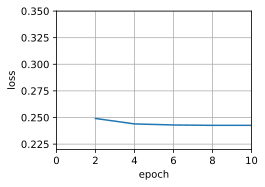

In [9]:
'''
封装get_data_ch11和train_ch11
固定优化器：使用sgd函数
参数映射：将输入的lr,batch_size,num_epochs传递给底层函数
'''
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = get_data_ch11(batch_size)
    '''
    'lr'：字典的键 （key），必须是不可变类型（字符串、数字、元组等）
    :：分隔键和值的冒号
    lr: 字典的值（value），可以是变量、字面量、表达式等
    {}：字典的界定符
    '''
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)
'''
lr=1：学习率设为1（相对较大的值）
batch_size=1500：批量大小等于数据集大小
get_data_ch1默认n=1500，因此这是梯度下降（GD）而非随机梯度下降
num_epochs=10：训练10轮
'''
gd_res = train_sgd(1, 1500, 10)

当批量大小为1时，优化使用的是随机梯度下降。
为了简化实现，我们选择了很小的学习率。
在随机梯度下降的实验中，每当一个样本被处理，模型参数都会更新。
在这个例子中，这相当于每个迭代轮数有1500次更新。
可以看到，目标函数值的下降在1个迭代轮数后就变得较为平缓。
尽管两个例子在一个迭代轮数内都处理了1500个样本，但实验中随机梯度下降的一个迭代轮数耗时更多。
这是因为随机梯度下降更频繁地更新了参数，而且一次处理单个观测值效率较低。


loss: 0.243, 0.128 sec/epoch


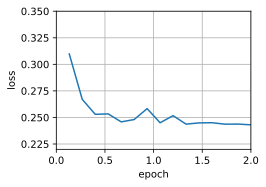

In [10]:
sgd_res = train_sgd(0.005, 1)

最后，当批量大小等于100时，我们使用小批量随机梯度下降进行优化。
每个迭代轮数所需的时间比随机梯度下降和批量梯度下降所需的时间短。


loss: 0.246, 0.006 sec/epoch


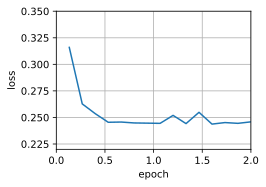

In [11]:
mini1_res = train_sgd(.4, 100)

将批量大小减少到10，每个迭代轮数的时间都会增加，因为每批工作负载的执行效率变得更低。


loss: 0.244, 0.018 sec/epoch


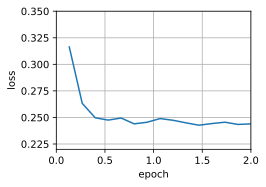

In [12]:
mini2_res = train_sgd(.05, 10)

**分解执行流程：**<br>
**假设每个xxx_res的结构：**<br>
```Python
gd_res = (time_list, loss_list)  # 元组：(时间累积列表, 损失列表)
sgd_res = (time_list, loss_list)
mini1_res = (time_list, loss_list)
mini2_res = (time_list, loss_list)
```
**步骤1：zip(...) —— 打包元组**
```Python
zip(gd_res, sgd_res, mini1_res, mini2_res)
将4个结果元组打包成一个迭代器：
[(gd_time, gd_loss), (sgd_time, sgd_loss), (mini1_time, mini1_loss), (mini2_time, mini2_loss)]
```
**步骤2：map(list, ...) —— 转换为列表**
```Python
map(list, zip(...))
将每个元组转换为列表：
[[gd_time, gd_loss], [sgd_time, sgd_loss], [mini1_time, mini1_loss], [mini2_time, mini2_loss]]
```
**步骤3：list(...) —— 完成转换**
```Python
list(map(...))
得到最终的列表：
[
  [gd_time, gd_loss],      # 索引0
  [sgd_time, sgd_loss],    # 索引1
  [mini1_time, mini1_loss], # 索引2
  [mini2_time, mini2_loss]  # 索引3
]
```
**步骤4：*—— 解包为位置参数**
```Python
*list(...)
解包后等价于：
d2l.plot(
    [gd_time, gd_loss],    # 第1个参数（x轴数据）
    [sgd_time, sgd_loss],  # 第2个参数（y轴数据）
    [mini1_time, mini1_loss], # 第3个参数
    [mini2_time, mini2_loss], # 第4个参数
    'time (sec)',          # 第5个参数（x轴标签）
    'loss',                # 第6个参数（y轴标签）
    xlim=[1e-2, 10],       # 第7个参数（x轴范围）
    legend=['gd', 'sgd', 'batch size=100', 'batch size=10'] # 第8个参数
)
```

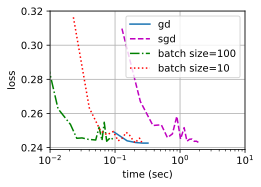

In [13]:
d2l.set_figsize([6, 3])
d2l.plot(*list(map(list, zip(gd_res, sgd_res, mini1_res, mini2_res))),
         'time (sec)', 'loss', xlim=[1e-2, 10],
         legend=['gd', 'sgd', 'batch size=100', 'batch size=10'])
'''
gca()：获取当前坐标轴（Get Current Axes）
set_xscale('log')：将x轴设置为对数刻度
原因：不同算法的训练时间可能跨越多个数量级（0.01秒到10秒），对数刻度能清晰展示早期快速收敛和后期精细调整两个阶段
'''
d2l.plt.gca().set_xscale('log')

## 简洁实现

下面用深度学习框架自带算法实现一个通用的训练函数，我们将在本章中其它小节使用它。


In [14]:
'''
trainer_fn：优化器工厂（如 torch.optim.SGD,torch.optim.Adam）
hyperparams：超参数字典（如 {'lr':0.1,'momentum':0.9}）
data_iter：数据迭代器
num_epochs：训练轮数（默认4轮）
'''
#@save
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # 初始化模型
    # 创建线性回归模型：输入5维（feature_dim=5），输出1维
    # nn.Sequential：容器，按顺序组织层
    net = nn.Sequential(nn.Linear(5, 1))
    '''
    init_weights(m)：对模块m初始化权重
    type(m)==nn.Linear：仅处理线性层
    torch.nn.init.normal_(m.weight,std=0.01)：用正态分布N(0,0.01^2)初始化权重
    net.apply(init_weights)  ：递归地对net中每个子模块应用init_weights
    作用：避免默认的Xavier/Kaiming初始化，与之前手动实现保持一致
    '''
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    # trainer_fn：优化器类（如torch.optim.SGD）
    # net.parameters()：获取模型所有可训练参数（w和b）;hyperparams：解包超参数字典，作为关键字参数传入
    optimizer = trainer_fn(net.parameters(), **hyperparams)
    # 均方误差损失
    # reduction='none'：不自动求和或平均，返回每个样本的损失;后续通过.mean()手动取平均，与手动实现保持一致
    loss = nn.MSELoss(reduction='none')
    '''
    动态绘图器：实时显示损失下降曲线
    xlim=[0,num_epochs]：x轴范围0到总轮数
    ylim=[0.22,0.35]：y轴范围0.22到0.35（适配本数据集）
    '''
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    # n：计数器，记录已处理的样本总数（用于每200样本更新一次图像）
    # timer：计时器，测量每轮平均耗时
    n, timer = 0, d2l.Timer()
    # 1. 外层循环：遍历轮次
    # _：轮次计数器占位符（不需要显式使用）;num_epochs：总训练轮数（默认4轮）
    for _ in range(num_epochs):
        '''
        2. 内层循环：遍历批次
        X：小批量特征，形状[batch_size,feature_dim]
        y：小批量标签，形状[batch_size]（真实数据）
        data_iter：数据迭代器（由get_data_ch11返回）
        '''
        for X, y in data_iter:
            optimizer.zero_grad() # 3. 梯度清零
            # 4. 前向传播
            # net：nn.Sequential(nn.Linear(5,1)) 定义的线性模型;out：模型预测值，形状[batch_size,1]
            out = net(X)
            '''
            5. 调整标签形状
            原因：out形状是[batch_size,1]，而y原始形状是[batch_size]
            操作：将y重塑为[batch_size,1]，与out形状一致
            目的：避免广播机制带来的潜在问题，确保损失计算正确
            '''
            y = y.reshape(out.shape)
            '''
            6. 计算损失
            loss：nn.MSELoss(reduction='none')（均方误差，不减少维度）
            l：每个样本的损失值，形状[batch_size,1]
            计算方式：(out−y)^2（不带系数 1/2）
            '''
            l = loss(out, y)
            '''
            7. 反向传播
            l.mean()：计算batch内所有样本损失的平均值，得到标量
            .backward()：对平均损失执行反向传播，计算参数梯度
            梯度存储：w.grad和b.grad被赋值为当前batch的梯度
            '''
            l.mean().backward()
            # 8. 参数更新
            # 作用：根据梯度和学习率等超参数，更新模型参数w和b
            # 内部逻辑：对SGD即 w-=lr*w.grad，对Adam更复杂
            optimizer.step()
            '''
            9. 累加样本数
            X.shape[0]：当前batch的样本数量（通常是batch_size）
            n：从训练开始至今总共处理的样本数
            '''
            n += X.shape[0]
            # 10. 每处理200个样本，更新可视化
            # 触发条件：n 是200的倍数时执行;目的：避免过于频繁地更新图像（影响性能），每200样本更新一次足够观察趋势
            if n % 200 == 0:
                # 11. 暂停计时
                # 作用：暂停计时器，排除绘图和评估的时间,确保：timer 只记录纯训练时间（前向+反向+更新）
                timer.stop()
                # MSELoss计算平方误差时不带系数1/2
                # 12. 更新动态损失曲线（核心可视化）
                '''
                参数1：训练进度
                计算：n/X.shape[0]=已处理的batch数
                再除以 len(data_iter)（每轮总batch数）=当前epoch比例（0到1）
                作用：x轴显示训练进度（如0.5表示第0.5个epoch）
                参数2：评估损失
                d2l.evaluate_loss(...)：在整个数据集上评估平均损失（每个样本的损失）
                /2 ：因为PyTorch的MSELoss计算的是平方误差，而手动实现时通常带系数1/2
                教学一致性：让两条曲线（手动版与简洁版）可比
                (...,)：元组形式，适配animator.add接口
                '''
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start() # 13. 重新开始计时:继续记录后续训练时间
    '''
    14. 打印最终统计信息
    animator.Y[0][-1]：
    animator.Y[0]：损失值历史列表
    [-1]：列表最后一个元素（最终损失）
    timer.avg():.3f：
    timer.avg()：计算平均每轮耗时（秒）
    :.3f：保留3位小数
    '''
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

下面使用这个训练函数，复现之前的实验。


loss: 0.242, 0.028 sec/epoch


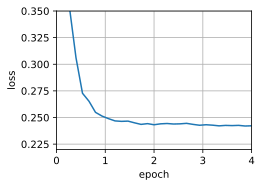

In [15]:
'''
get_data_ch11(10)：加载"airfoil"数据集，批量大小为10
返回：(data_iter, feature_dim)，其中feature_dim=5
_, ：用下划线_忽略第二个返回值**特征维度，因为train_concise_ch11内部会自动从数据推断维度（通过nn.Linear(5,1)）
'''
data_iter, _ = get_data_ch11(10)
'''
torch.optim.SGD：PyTorch提供的SGD优化器类（不是实例）
注意：这里传递的是类本身，而非实例化对象
原因：train_concise_ch11内部会调用trainer_fn(net.parameters(),**hyperparams)来动态实例化优化器
'''
trainer = torch.optim.SGD
'''
trainer：torch.optim.SGD 类
{'lr':0.01}：超参数字典，指定学习率为0.01
data_iter：数据迭代器（批量大小为10）
'''
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)